<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-train,-test,-and-validation-sets" data-toc-modified-id="Prepare-train,-test,-and-validation-sets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare train, test, and validation sets</a></span></li><li><span><a href="#Exploratory-Data-Analysis-(EDA)" data-toc-modified-id="Exploratory-Data-Analysis-(EDA)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis (EDA)</a></span><ul class="toc-item"><li><span><a href="#Class-distribution" data-toc-modified-id="Class-distribution-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Class distribution</a></span></li><li><span><a href="#Sentence-length-distribution" data-toc-modified-id="Sentence-length-distribution-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sentence length distribution</a></span></li></ul></li><li><span><a href="#Load-Word-Embedding" data-toc-modified-id="Load-Word-Embedding-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Word Embedding</a></span></li><li><span><a href="#Prepare-features-(X)-and-labels-(Y)" data-toc-modified-id="Prepare-features-(X)-and-labels-(Y)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prepare features (X) and labels (Y)</a></span><ul class="toc-item"><li><span><a href="#Tokenization-and-padding" data-toc-modified-id="Tokenization-and-padding-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Tokenization and padding</a></span></li><li><span><a href="#Creating-an-embedding-matrix" data-toc-modified-id="Creating-an-embedding-matrix-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Creating an embedding matrix</a></span></li><li><span><a href="#Encoding-the-labels" data-toc-modified-id="Encoding-the-labels-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Encoding the labels</a></span></li></ul></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Evaluation</a></span><ul class="toc-item"><li><span><a href="#Define-the-functions-for-ploting" data-toc-modified-id="Define-the-functions-for-ploting-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Define the functions for ploting</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#GRU" data-toc-modified-id="GRU-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>GRU</a></span><ul class="toc-item"><li><span><a href="#Define-the-model" data-toc-modified-id="Define-the-model-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>Define the model</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-5.3.2"><span class="toc-item-num">5.3.2&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Save-the-model" data-toc-modified-id="Save-the-model-5.3.3"><span class="toc-item-num">5.3.3&nbsp;&nbsp;</span>Save the model</a></span></li></ul></li><li><span><a href="#CNN" data-toc-modified-id="CNN-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>CNN</a></span><ul class="toc-item"><li><span><a href="#Define-the-model" data-toc-modified-id="Define-the-model-5.4.1"><span class="toc-item-num">5.4.1&nbsp;&nbsp;</span>Define the model</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-5.4.2"><span class="toc-item-num">5.4.2&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Save-the-model" data-toc-modified-id="Save-the-model-5.4.3"><span class="toc-item-num">5.4.3&nbsp;&nbsp;</span>Save the model</a></span></li></ul></li><li><span><a href="#Transformer-(TODO)" data-toc-modified-id="Transformer-(TODO)-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Transformer (TODO)</a></span></li></ul></li><li><span><a href="#Make-the-prediction-on-the-test-set" data-toc-modified-id="Make-the-prediction-on-the-test-set-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Make the prediction on the test set</a></span><ul class="toc-item"><li><span><a href="#Train-the-model-on-whole-trainig-set" data-toc-modified-id="Train-the-model-on-whole-trainig-set-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Train the model on whole trainig set</a></span></li><li><span><a href="#Make-the-prediction-on-the-test-set" data-toc-modified-id="Make-the-prediction-on-the-test-set-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Make the prediction on the test set</a></span></li></ul></li><li><span><a href="#Without-using-pretrained-word-embedding" data-toc-modified-id="Without-using-pretrained-word-embedding-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Without using pretrained word embedding</a></span></li><li><span><a href="#Future-Work" data-toc-modified-id="Future-Work-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Future Work</a></span></li></ul></div>

 
Which Novel Do I Belong To?

In this task, you are expected to learn a Machine Learning model that classifies a given line as belonging to one of the following 12 novels:

0: alice_in_wonderland
1: dracula
2: dubliners
3: great_expectations
4: hard_times
5: huckleberry_finn
6: les_miserable
7: moby_dick
8: oliver_twist
9: peter_pan
10: talw_of_two_cities
11: tom_sawyer


Description:

You are provided with a zip file (offline_challenge.zip) containing three text files - xtrain.txt, ytrain.txt, xtest.txt. Each line in xtrain.txt and xtest.txt comes from a different novel. The data has been obfuscated, however the patterns in them are preserved. The novel ids corresponding to xtrain.txt are specified in ytrain.txt. You can use these labels to train a Machine Learning model (Deep Learning preferred).

With the learned model, predict the novel ids of the lines in xtest.txt (one prediction per line). As part of your submission, include

a) your predictions (in the same format as ytrain.txt)
b) Expected accuracy on the test set
c) the source code for training and prediction (< 10MB)
d) a brief description of your method (optional)


In [400]:
import string

import collections

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np # linear algebra
from numpy import genfromtxt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import keras
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling1D, Conv1D, GlobalMaxPool1D, Bidirectional
from keras.layers import LSTM, Lambda, Bidirectional, concatenate, BatchNormalization, Embedding
from keras.layers import Reshape, RepeatVector
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model


## Prepare train, test, and validation sets


In [154]:

with open(x_train_file) as f:
    x_train_all = f.read().strip().lower().split('\n')
    
with open(y_train_file) as f:
    y_train = f.read().strip().split('\n')
for i in range(len(ytrain)):
    y_train[i] = int(ytrain[i])

with open(x_test_file) as f:
    x_test = f.read().strip().lower().split('\n')
    
    

In [155]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train, test_size=0.2, random_state=42)


## Exploratory Data Analysis (EDA)


### Class distribution


In [297]:
collections.Counter(y_train_all)


Counter({6: 4226,
         7: 5097,
         8: 3634,
         11: 1408,
         3: 4023,
         0: 543,
         4: 2337,
         5: 2283,
         1: 3459,
         10: 3052,
         2: 1471,
         9: 980})

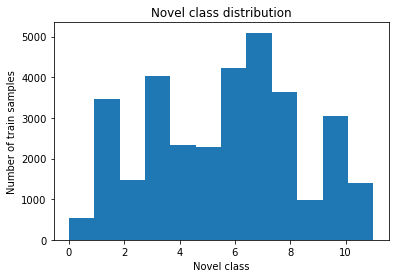

In [298]:
plt.hist(y_train_all, 
         bins=12,
        )

plt.xlabel("Novel class")
plt.ylabel("Number of train samples")
plt.title("Novel class distribution")
plt.show()


It shows that the data is imbalanced. Classes '0' and '10' have very few samples.


### Sentence length distribution


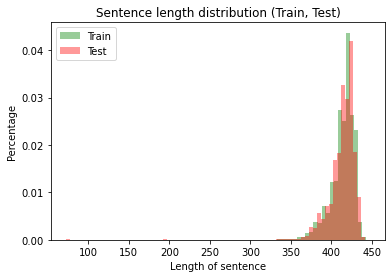

In [315]:
sent_len_train = [len(sent) for sent in x_train_all]
sent_len_test = [len(sent) for sent in x_test]

plt.hist(sent_len_train, 
         bins=range(min(sent_len_train), max(sent_len_train) + 1, 5),
         alpha=0.4,
         density=True,
         color='green',
        )

plt.hist(sent_len_test, 
         bins=range(min(sent_len_test), max(sent_len_test) + 1, 5),
         alpha=0.4,
         density=True,
         color='red',
        )

labels = ['Train',"Test"]
plt.legend(labels)
plt.xlabel("Length of sentence")
plt.ylabel("Percentage")
plt.title("Sentence length distribution (Train, Test)")


plt.show()


## Load Word Embedding



**Reference**

* What Are Word Embeddings for Text?

https://machinelearningmastery.com/what-are-word-embeddings/


https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

https://dzone.com/articles/glove-and-fasttext-two-popular-word-vector-models

https://mc.ai/word-embeddings-in-nlp-word2vec-glove-fasttext/


- fastText


https://www.quora.com/What-is-the-difference-between-fastText-and-GloVe

What is the difference between fastText and GloVe?

"
Key difference is Glove treats each word in corpus like an atomic entity and generates a vector for each word. 
In this sense Glove is very much like word2vec- both treat words as the smallest unit to train on.

Fasttext which is essentially an extension of word2vec model, treats each word as composed of character ngrams. 
So the vector for a word is made of the sum of this character n grams. This difference enables fasttext to

- Generate better word embeddings for rare words 
( even if words are rare their character n grams are still shared with other words - hence the embeddings can still be good)

- Out of vocabulary words - they can construct the vector for a word from its character n grams even if word doesn't appear in training corpus. Both Glove and word2vec can't.
"





In [217]:
def get_embedding(embedding_file):
    embedding_dict = {}
    with open(embedding_file) as f:
        for line in tqdm(f):
            values = line.split()
            word = values[0]
            embedding_dict[word] = np.asarray(values[1:], dtype='float32')
    return embedding_dict



In [218]:
#glove_path = '../glove.6B.300d.txt'
#glove_path = '../glove.840B.300d.txt'
#glove_embedding = {}
#glove_embedding = get_embedding(glove_path)

#fasttext_path = '../wiki-news-300d-1M.vec'
fasttext_path = '../crawl-300d-2M.vec'
fasttext_embedding = {}
fasttext_embedding = get_embedding(fasttext_path)


400000it [00:35, 11409.46it/s]
1999996it [02:52, 11590.40it/s]


## Prepare features (X) and labels (Y)



### Tokenization and padding


In [276]:

max_features = None
token = text.Tokenizer(num_words=max_features, char_level=True)

token.fit_on_texts(list(x_train_all) + list(x_test))
x_train_seq = token.texts_to_sequences(x_train)
x_train_all_seq = token.texts_to_sequences(x_train_all)
x_valid_seq = token.texts_to_sequences(x_valid)
x_test_seq = token.texts_to_sequences(x_test)

#zero pad the sequences
# max_sent_len = 200
max_sent_len = max([len(sent) for sent in x_train_all])
x_train_seq = sequence.pad_sequences(x_train_seq, maxlen=max_sent_len)
x_train_all_seq = sequence.pad_sequences(x_train_all_seq, maxlen=max_sent_len)
x_valid_seq = sequence.pad_sequences(x_valid_seq, maxlen=max_sent_len)
x_test_seq = sequence.pad_sequences(x_test_seq, maxlen=max_sent_len)

word_index = token.word_index


In [277]:
print(len(x_train_seq))
print(len(x_train_all_seq))
print(len(x_valid_seq))
print(len(x_test_seq))

print(len(x_train_seq[0]))

print(x_train_seq[0])
print(word_index)


26010
32513
6503
3000
452
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 15 12  4  9  5 14 12 17  1  2 13 17 15 12  8  7
  6  5  8  7 15 12  3  4 13  4  4  9 10  3 21 10  1  2  8  7 11  3 13  4
  1  2  9 25 13 17  8  7  4  9 10  3  1  2 10  3  1  6  4  9  3  4  1  2
  1  6  8  7  6 16  1  2  9  7  9  7  3  4 19 20  1  2  8  7 11  3 22 21
 12 17  1  2  1  2 16 11  1  6 13  4  8  7 12 16 15 18  8  7  6  5  1  2
  1  6  5 14  8  7  6  5  6 16  1  2  4  9  3  4  1  2  8  7  6  5  8  7
 19 20  1  2 11  3 21 10  3  4 11  3 19 20  1  2 13 17 13  4  8  7 11  3
 21 10  5 14 10  3 21 10  1  2  6 16  4  9  3  4  1  6  3  4  5 14 19 20
  1  2  8  7 11  3  1  6  1  2 13  4 15 12  6  5  5 14 19 20 10  3  1  6
  1  2 13  4  8  7 15 11  8  7  1  2 15 12  8  7  1  6 21 10  5 14  6  5
  1  6 13  4  3  4 15 12  1  2  6  5  8  7 11  3  1  2 15 12  8  7  4  9
  6  5 12 16  1  6  1  2  1  6  3  4 13  4  6  5  5 14 17 18 22 21  1  2
 16 11 13  4  6  5 13 25 

### Creating an embedding matrix


In [278]:
embedding_len=300


In [279]:

def get_embedding_matrix(embedding, 
                         word_index, 
                         embedding_len=300):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_len))
    for word, i in tqdm(word_index.items()):
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
        
    

In [281]:

fasttext_embedding_matrix = get_embedding_matrix(embedding=fasttext_embedding,
                                                 word_index=word_index,
                                                 embedding_len=embedding_len,
                                                )


100%|██████████| 26/26 [00:00<00:00, 29173.86it/s]


### Encoding the labels


In [282]:

y_train_en = np_utils.to_categorical((y_train))
y_train_all_en = np_utils.to_categorical((y_train_all))
y_valid_en = np_utils.to_categorical((y_valid))



## Model Evaluation



### Define the functions for ploting


In [353]:

def plot_confusion_matrix(y_test, y_pred):
    confusion_mtx = confusion_matrix(y_test, y_pred) 
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    return

def plot_learning_curves(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')

    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')
    pyplot.legend()
    pyplot.show()
    
    #filename = sys.argv[0].split('/')[-1]
    #pyplot.savefig(filename + '_plot.png')
    #pyplot.close()
    #image = imread(filename + '_plot.png')
    #pyplot.figure(figsize=(10, 25))
    #pyplot.imshow(image)
    return 


### Parameters


In [335]:
n_classes = 12
batch_size = 32
epochs = 60

model_dict = {}


### GRU


**Reference**

* A Tour of Recurrent Neural Network Algorithms for Deep Learning

https://machinelearningmastery.com/recurrent-neural-network-algorithms-for-deep-learning/


#### Define the model

In [415]:
def define_gru_model(word_index, 
                     max_sent_len, 
                     embedding_matrix,
                     embedding_size=0,
                    ):
    
    model = Sequential()
    
    if embedding_matrix is None:
        model.add(Embedding(len(word_index) + 1, 
                            embedding_size, 
                            input_length=max_sent_len,
                           ))
    else:
        model.add(Embedding(len(word_index) + 1,
                             embedding_matrix.shape[1],
                             weights=[embedding_matrix],
                             input_length=max_sent_len,
                             trainable=False))
    
    model.add(SpatialDropout1D(0.3))
    model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3))
    #model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
    #model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3))
    #model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model


#### Train the model


About early stopping

https://medium.com/ai%C2%B3-theory-practice-business/dropout-early-stopping-188a23beb2f9


In [416]:

model = define_gru_model(word_index=word_index, 
                         max_sent_len=max_sent_len, 
                         embedding_matrix=fasttext_embedding_matrix,
                        )

# Fit the model with early stopping callback
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history = model.fit(x=x_train_seq, 
                    y=y_train_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(x_valid_seq, y_valid_en),
                    #callbacks=[earlystop],
                   )

plot_learning_curves(history)

model_dict['gru_fasttext'] = model


Epoch 1/60
 13/813 [..............................] - ETA: 7:55 - loss: 2.5022 - acc: 0.0817

KeyboardInterrupt: 

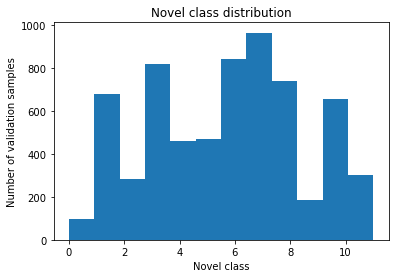

In [338]:
plt.hist(y_valid, 
         bins=12,
        )

plt.xlabel("Novel class")
plt.ylabel("Number of validation samples")
plt.title("Novel class distribution")
plt.show()


In [339]:
y_pred_val = model.predict_classes(x_valid_seq)


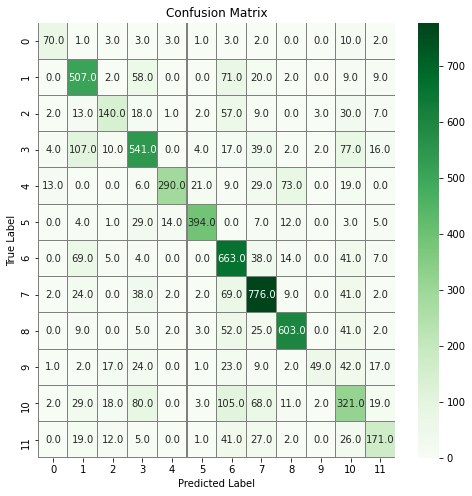

In [340]:
plot_confusion_matrix(y_valid, y_pred_val)


In [341]:
print(classification_report(y_valid, y_pred_val))


              precision    recall  f1-score   support

           0       0.74      0.71      0.73        98
           1       0.65      0.75      0.69       678
           2       0.67      0.50      0.57       282
           3       0.67      0.66      0.66       819
           4       0.93      0.63      0.75       460
           5       0.91      0.84      0.87       469
           6       0.60      0.79      0.68       841
           7       0.74      0.80      0.77       965
           8       0.83      0.81      0.82       742
           9       0.88      0.26      0.40       187
          10       0.49      0.49      0.49       658
          11       0.67      0.56      0.61       304

    accuracy                           0.70      6503
   macro avg       0.73      0.65      0.67      6503
weighted avg       0.71      0.70      0.69      6503



#### Save the model


In [342]:
model_dict['gru_fasttext'].save('gru_fasttext_{}.h5'.format(epochs))


### CNN


**Reference**

* How to Develop a Multichannel CNN Model for Text Classification


https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/

https://www.kaggle.com/kmader/character-level-cnn-classification-with-dilations

https://machinelearningmastery.com/best-practices-document-classification-deep-learning/



#### Define the model


In [343]:
def define_cnn_model(word_index, 
                     max_sent_len,
                     embedding_matrix,
                     embedding_size=0,
                    ):
    model = Sequential()
    
    if embedding_matrix is None:
        model.add(Embedding(len(word_index) + 1, 
                            embedding_size, 
                            input_length=max_sent_len,
                           ))
    else:
        model.add(Embedding(len(word_index) + 1,
                             embedding_matrix.shape[1],
                             weights=[embedding_matrix],
                             input_length=max_sent_len,
                             trainable=False))
    model.add(Dropout(0.3))

    # add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(128,
                     5,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(5))
    model.add(Conv1D(128,
                     5,
                     activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(BatchNormalization())
    model.add(Conv1D(128,
                     5,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(3))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    
    return model
    
    

#### Train the model


Epoch 1/60
813/813 [==============================] - 104s 127ms/step - loss: 2.2749 - acc: 0.2043 - val_loss: 2.1145 - val_acc: 0.2088
Epoch 2/60
813/813 [==============================] - 103s 127ms/step - loss: 1.8116 - acc: 0.3633 - val_loss: 2.3080 - val_acc: 0.2713
Epoch 3/60
813/813 [==============================] - 103s 127ms/step - loss: 1.5344 - acc: 0.4692 - val_loss: 2.1359 - val_acc: 0.3843
Epoch 4/60
813/813 [==============================] - 104s 128ms/step - loss: 1.3817 - acc: 0.5200 - val_loss: 2.9053 - val_acc: 0.3551
Epoch 5/60
813/813 [==============================] - 108s 132ms/step - loss: 1.2657 - acc: 0.5621 - val_loss: 3.5777 - val_acc: 0.2467
Epoch 6/60
813/813 [==============================] - 106s 130ms/step - loss: 1.1756 - acc: 0.5939 - val_loss: 1.4860 - val_acc: 0.4878
Epoch 7/60
813/813 [==============================] - 105s 129ms/step - loss: 1.0915 - acc: 0.6262 - val_loss: 2.4016 - val_acc: 0.4418
Epoch 8/60
813/813 [============================

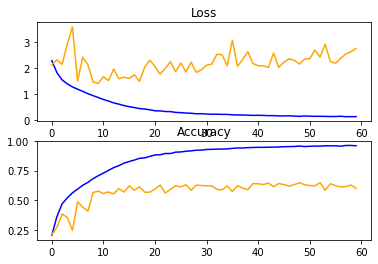

In [344]:

model = define_cnn_model(word_index=word_index, 
                         max_sent_len=max_sent_len,
                         embedding_matrix=fasttext_embedding_matrix,
                        )

#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(x=x_train_seq, 
                    y=y_train_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(x_valid_seq, y_valid_en),
                    #callbacks=[earlystop],
                   )

plot_learning_curves(history)

model_dict['1dcnn_fasttext'] = model


In [345]:
y_pred_val = model.predict_classes(x_valid_seq)


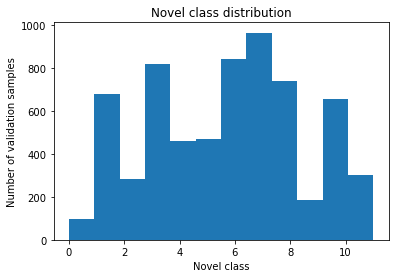

In [346]:
plt.hist(y_valid, 
         bins=12,
        )

plt.xlabel("Novel class")
plt.ylabel("Number of validation samples")
plt.title("Novel class distribution")
plt.show()


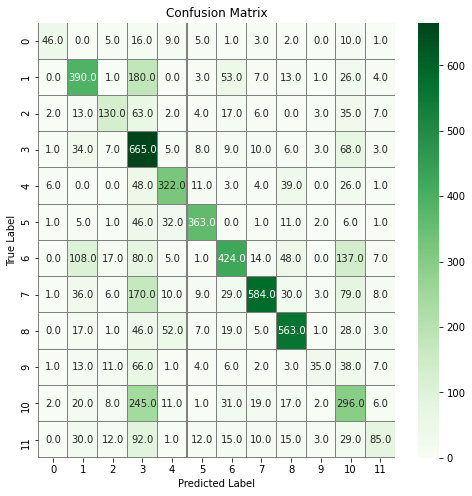

In [347]:
plot_confusion_matrix(y_valid, y_pred_val)


In [348]:
print(classification_report(y_valid, y_pred_val))


              precision    recall  f1-score   support

           0       0.77      0.47      0.58        98
           1       0.59      0.58      0.58       678
           2       0.65      0.46      0.54       282
           3       0.39      0.81      0.52       819
           4       0.72      0.70      0.71       460
           5       0.85      0.77      0.81       469
           6       0.70      0.50      0.59       841
           7       0.88      0.61      0.72       965
           8       0.75      0.76      0.76       742
           9       0.66      0.19      0.29       187
          10       0.38      0.45      0.41       658
          11       0.64      0.28      0.39       304

    accuracy                           0.60      6503
   macro avg       0.66      0.55      0.57      6503
weighted avg       0.66      0.60      0.60      6503



#### Save the model


In [349]:
model_dict['1dcnn_fasttext'].save('1dcnn_fasttext_{}.h5'.format(epochs))


### Transformer (TODO)


https://atheros.ai/blog/text-classification-with-transformers-in-tensorflow-2

https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert



## Make the prediction on the test set



### Train the model on whole trainig set


In [350]:
epochs = 100


In [351]:
# model = load_model('1dcnn_fasttext_{}.h5'.format(100))
#model = define_cnn_model(word_index=word_index, 
#                         max_sent_len=max_sent_len,
#                         embedding_matrix=fasttext_embedding_matrix,
#                        )

#model = load_model('gru_fasttext_{}.h5'.format(60))
model = define_gru_model(word_index=word_index, 
                         max_sent_len=max_sent_len,
                         embedding_matrix=fasttext_embedding_matrix,
                        )

history = model.fit(x=x_train_all_seq, 
                    y=y_train_all_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    #validation_data=(x_valid_seq, y_valid_en),
                    #callbacks=[earlystop],
                   )

model_dict['cnn_fasttext_final'] = model

model_dict['cnn_fasttext_final'].save('cnn_fasttext_final_{}.h5'.format(epochs))



Epoch 1/100
1017/1017 [==============================] - 129s 127ms/step - loss: 2.4113 - acc: 0.1439
Epoch 2/100
1017/1017 [==============================] - 119s 117ms/step - loss: 2.3611 - acc: 0.1564
Epoch 3/100
1017/1017 [==============================] - 123s 121ms/step - loss: 2.3517 - acc: 0.1565
Epoch 4/100
1017/1017 [==============================] - 120s 118ms/step - loss: 2.3502 - acc: 0.1566
Epoch 5/100
1017/1017 [==============================] - 121s 119ms/step - loss: 2.3472 - acc: 0.1564
Epoch 6/100
1017/1017 [==============================] - 121s 119ms/step - loss: 2.3461 - acc: 0.1568
Epoch 7/100
1017/1017 [==============================] - 127s 125ms/step - loss: 2.3464 - acc: 0.1565
Epoch 8/100
 681/1017 [===================>..........] - ETA: 49s - loss: 2.3412 - acc: 0.1594

KeyboardInterrupt: 

In [ ]:
plot_learning_curves(history)


### Make the prediction on the test set


In [ ]:
predictions = model.predict_classes(x_test_seq)


In [ ]:
len(predictions)

In [ ]:
with open('ytest.txt', 'w') as f:
    for pred in predictions:
        f.write("%s\n" % pred)


In [ ]:
"""
# test the save function

y_test = []
with open('ytest.txt') as f:
    y_test = f.read().strip().split('\n')

y_test = [int(y) for y in y_test]
print(len(y_test))
print(y_test[0])
"""



## Without using pretrained word embedding


In [411]:

def get_word_index_feat(sentences, max_sent_len, alpha_index_dict):
    set_size = len(sentences)
    x = np.zeros((set_size, max_sent_len), dtype=np.int)
    for i in range(set_size):
        sent = np.zeros(max_sent_len, dtype=np.int)
        for j in range(max_sent_len):
            if j < len(sentences[i]):
                sent[j] = alpha_index_dict[sentences[i][j]]
            else:
                sent[j] = 0
        x[i] = np.copy(sent)
    return x


In [412]:
x_train_wordindex = get_word_index_feat(x_train, max_sent_len, word_index)
x_train_all_wordindex = get_word_index_feat(x_train_all, max_sent_len, word_index)
x_valid_wordindex = get_word_index_feat(x_valid, max_sent_len, word_index)
x_test_wordindex = get_word_index_feat(x_test, max_sent_len, word_index)


In [413]:
epochs = 20


In [414]:

model = define_gru_model(word_index=word_index, 
                         max_sent_len=max_sent_len, 
                         embedding_matrix=None,
                         embedding_size=20,
                        )
    
history = model.fit(x=x_train_wordindex, 
                    y=y_train_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    #validation_data=(x_valid_seq, y_valid_en),
                    #callbacks=[earlystop],
                   )

plot_learning_curves(history)

model_dict['gru_word_index'] = model

model_dict['gru_word_index'].save('gru_word_index_{}.h5'.format(epochs))



Epoch 1/60
565/813 [===================>..........] - ETA: 1:48 - loss: 2.3736 - acc: 0.1480

KeyboardInterrupt: 

## Future Work
